# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
%%script false --no-raise-error
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import math

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
%%script false --no-raise-error

# Standard transformation for MNIST dataset.
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load MNIST train and test datasets.
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Create validation set from training data.
validation_size = 5000
permuted_indices = np.random.permutation(len(mnist_train_full))
mnist_validation = Subset(mnist_train_full, permuted_indices[:validation_size])
mnist_train = Subset(mnist_train_full, permuted_indices[validation_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
%%script false --no-raise-error

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Train the model for one epoch using the provided data loader.
def train_one_epoch(model, dataloader, optimizer, epoch_label='Unknown', device='cpu'):
    model.train()
    epoch_losses = []
    for inputs, targets in tqdm(dataloader, desc=f'Training epoch {epoch_label}', leave=True):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    return np.mean(epoch_losses)

# Evaluate the model on the entire dataset provided by the data loader.
def evaluate_model_performance(model, dataloader, device='cpu'):
    model.eval()
    all_predictions = []
    all_targets = []

    for inputs, targets in tqdm(dataloader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        logits = model(inputs)
        preds = torch.argmax(logits, dim=1)

        all_targets.append(targets)
        all_predictions.append(preds.detach().cpu().numpy())
        
    targets_flat = np.hstack(all_targets)
    predictions_flat = np.hstack(all_predictions)

    return (
        accuracy_score(targets_flat, predictions_flat),
        classification_report(targets_flat, predictions_flat, zero_division=0, digits=3)
    )

# Plot training loss and validation accuracy across epochs.
def plot_training_curves(metrics_per_epoch):
    training_losses = [loss for (loss, _) in metrics_per_epoch]
    validation_accuracies = [acc for (_, acc) in metrics_per_epoch]

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(training_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(validation_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    best_epoch = np.argmax(validation_accuracies)
    best_accuracy = np.max(validation_accuracies)
    plt.title(f'Best Accuracy = {best_accuracy} @ epoch {best_epoch}')


#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
%%script false --no-raise-error

class FeedForwardMLP(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()
        self.linear_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) 
            for in_features, out_features in zip(layer_dims[:-1], layer_dims[1:])
        ])
    
    def forward(self, x):
        # Apply a sequence of Linear + ReLU (except last) in a functional style
        return reduce(
            lambda composed, layer: lambda x: layer(F.relu(composed(x))),
            self.linear_layers,
            lambda x: x.flatten(1)
        )(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [5]:
%%script false --no-raise-error

# Device and training hyperparameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

num_epochs = 30
learning_rate = 0.01
batch_size = 512

# Model architecture parameters.
input_dim = 28 * 28
# hidden_width = 16
# hidden_depth = 2

# Data loaders.
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, num_workers=4)
test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

# Model and optimizer setup.
mlp_model = FeedForwardMLP([input_dim, 256, 128, 10]).to(device)  # or: [hidden_width] * hidden_depth + [10]
optimizer = torch.optim.Adam(params=mlp_model.parameters(), lr=learning_rate)

# Training loop.
training_metrics = []
for current_epoch in range(num_epochs):
    epoch_loss = train_one_epoch(mlp_model, train_loader, optimizer, current_epoch, device=device)
    val_accuracy, _ = evaluate_model_performance(mlp_model, val_loader, device=device)
    training_metrics.append((epoch_loss, val_accuracy))

# Plot performance curves.
plot_training_curves(training_metrics)

# Final evaluation on test set.
_, test_report = evaluate_model_performance(mlp_model, test_loader, device=device)
print(f'Accuracy report on TEST:\n{test_report}')


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [6]:
#some necessary imports for the entire notebook to run


import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms
from torchvision.models.resnet import BasicBlock, Bottleneck

from tqdm.auto import tqdm
import inspect
import numpy as np
import math
import random

/home/marco/miniforge3/envs/DLA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Set random seeds for reproducibility.
# Note: This is not a guarantee of reproducibility across different hardware or software versions.

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

## 🛠️ Working Paths

- **`DATA_DIR`**: Directory where data is or will be stored (e.g., MNIST dataset).  
- **`CHECKPOINTS_DIR`**: Path to save model checkpoints (`.pt` or `.pth` files).  
- **`LOGS_DIR`**: Directory for logs (e.g., for TensorBoard visualizations).

---

## ⚙️ Training Hyperparameters

- **`BATCH_SIZE = 128`**: Number of examples processed in parallel in each batch.  
- **`NUM_WORKERS = 4`**: Number of parallel workers for loading batches — speeds up data loading.  
- **`LEARNING_RATE = 1e-3`**: Initial learning rate.  
- **`EARLY_STOPPING_PATIENCE = 3`**: Regularization technique to avoid overfitting — stops training if the model doesn't improve for 3 consecutive epochs.  
- **`NUM_EPOCHS = 30`**: Maximum number of training epochs.

---

## 💻 Device Configuration

- **CUDA Detection**: Automatically detects if a CUDA-capable GPU is available.  
  - If available → use **GPU**  
  - Otherwise → use **CPU**
- **`device = torch.device(...)`**: Standard PyTorch approach to ensure code runs seamlessly on both GPU and CPU.



In [8]:
# Directory paths for dataset, model checkpoints, and logs.
DATA_DIR = './data'
CHECKPOINTS_DIR = './checkpoints'
LOGS_DIR = './logs'

# Training hyperparameters.
BATCH_SIZE = 128
NUM_WORKERS = 4
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 3
NUM_EPOCHS = 30

# Device setup.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [9]:
#TensorBoard setup. #This is your window to visualize tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir=./logs



## 🧹 `clear` Function

This utility function ensures a clean directory by:

1. Checking if the directory exists and is indeed a folder.
2. If so, it deletes the entire directory using `shutil.rmtree()`.
3. Then it recreates the directory using `os.makedirs(..., exist_ok=True)` — safe even if the directory already exists.

It is used to ensure a clean and repeatable environment during experiments, preventing old files (e.g. old saved weights or TensorBoard logs) from interfering with new ones.
Great in automated training pipelines (e.g. in batch scripts or multiple experiments).

In [10]:
import os
import shutil

def clear_directory(directory_path):
    """
    Deletes the contents of the given directory if it exists,
    then recreates an empty directory at the same path.
    """
    if os.path.exists(directory_path):
        if os.path.isdir(directory_path):
            shutil.rmtree(directory_path)
    os.makedirs(directory_path, exist_ok=True)

# Example usage to clear directories before starting training:
# clear_directory(DATA_DIR)
# clear_directory(CHECKPOINTS_DIR)
# clear_directory(LOGS_DIR)


In [11]:
# Import personal modules for training pipeline and model architectures.
from SLTrainingPipeline import SLTrainingPipeline
from MLP import MLP, ResMLP
from CNN import CNN, ResCNN


## 📊 `log_gradient_magnitudes` Function

### 🔍 What It Does

- Logs the **gradient norm** of the **first** and **last** layers to **TensorBoard**.
- Computes and logs the **ratio** between the two gradient norms.
- Activated every `log_interval` batches (e.g., every 32), **only during training**.

---

### ✅ Why It’s Useful

This function helps **diagnose vanishing or exploding gradients** — common issues in deep networks:

- If the **last layer’s gradient** is significantly **smaller** than the **first layer’s**, it may signal that gradients are not propagating effectively back through the network.
- This information can help in debugging training issues and choosing better architectures or learning rates.

---

### 🧠 Typical Use Case

> Use during training to **monitor gradient flow**, especially in deep or unstable models.


## 🧪 `monitor_initial_weight_change` Function

### 🔍 What It Does

- At **epoch 0**, it stores the **average of the weights** for each layer.
- At **epoch 1**, it compares the **updated weight averages** with the initial ones.
- Prints the **absolute change** in weights for each layer.

---

### ✅ Why It’s Useful

This function helps **monitor early weight updates**, which is critical for debugging training dynamics:

- If weights **do not change significantly**, it may indicate:
  - A **learning rate that is too low**
  - **Poor weight initialization**
  - **Vanishing gradients**

---

### 🧠 Typical Use Case

> Use during the first few epochs to verify that learning is actually happening and weights are being meaningfully updated.


In [12]:
# Callbacks for monitoring training dynamics and metrics.

def log_gradient_magnitudes(pipeline, **context):
    """
    Logs gradient magnitudes of first and last layers, plus their ratio,
    at regular intervals during training.
    """
    if not context.get("is_training", False) or not pipeline.writer:
        return

    log_interval = 32
    writer = pipeline.writer
    model = pipeline.model
    run_id = pipeline.run_id
    batch_size = context.get("batch_size", 64)
    global_step = pipeline.current_epoch * batch_size + pipeline.current_batch

    if global_step % log_interval != 0:
        return

    grad_params = [
        (idx, name, param)
        for idx, (name, param) in enumerate(model.named_parameters())
        if param.requires_grad and param.grad is not None and "bias" not in name
    ]

    if not grad_params:
        return

    first_idx, first_name, first_param = grad_params[0]
    last_idx, last_name, last_param = grad_params[-1]

    first_grad_norm = torch.norm(first_param.grad).item()
    last_grad_norm = torch.norm(last_param.grad).item()

    writer.add_scalar(f"grad_first_layer/{run_id}", first_grad_norm, global_step)
    writer.add_scalar(f"grad_last_layer/{run_id}", last_grad_norm, global_step)

    if first_grad_norm > 0:
        grad_ratio = last_grad_norm / first_grad_norm
        writer.add_scalar(f"grad_last_to_first_ratio/{run_id}", grad_ratio, global_step)

    writer.flush()


def monitor_initial_weight_change(pipeline, **context):
    """
    At the start of training, stores initial weights mean values,
    then after the first epoch prints how much weights changed.
    """
    if not context.get('is_training', False) or pipeline.current_batch != 0:
        return

    epoch = pipeline.current_epoch

    if epoch == 0:
        pipeline.callbacks_data['initial_weights'] = {
            name: param.data.clone().mean().item()
            for name, param in pipeline.model.named_parameters()
        }
    elif epoch == 1:
        print("Weight changes after first epoch:")
        for name, param in pipeline.model.named_parameters():
            initial_mean = pipeline.callbacks_data['initial_weights'][name]
            current_mean = param.data.mean().item()
            change = abs(current_mean - initial_mean)
            print(f"{name}: initial = {initial_mean:.6f}, current = {current_mean:.6f}, change = {change:.6f}")





## 🎯 `accuracy_metric` Function

### 🔍 What It Does

- Computes **accuracy** by comparing model **logits** (predictions) with the **true targets**.
- Typically used with `torch.argmax` to convert logits into predicted class labels.
- Can be stored in a **`metrics` dictionary** for modular and flexible use during training and evaluation loops.


Provides a custom accuracy metric.

In [13]:
# Dictionary registering callbacks by training event hooks.
gradient_callbacks = {
    # 'on_batch_begin': [monitor_initial_weight_change],
    'on_after_back': [log_gradient_magnitudes]
}


# Metrics definitions.

def accuracy_metric(logits, targets):
    _, predicted_labels = torch.max(logits.data, dim=1)
    return (predicted_labels == targets).float().mean().item()

metrics = {"accuracy": accuracy_metric}

## 🖼️ MNIST Transform & DataLoaders

### 🔍 What It Does

Applies standard preprocessing to MNIST images:

- **`ToTensor()`**:  
  Converts a PIL image to a PyTorch tensor of shape `[1, 28, 28]` with values in the range **[0, 1]**.

- **`Normalize((0.1307,), (0.3081,))`**:  
  Normalizes the single-channel (grayscale) image using the **mean** and **standard deviation** of the MNIST dataset.

- **Defines DataLoaders ready for training** 

---

### 🧠 Why It’s Useful

- **Normalization** improves:
  - **Training stability**
  - **Convergence speed**
  - **Numerical consistency** across batches

---

In [14]:
# MNIST dataset loading and preprocessing with train/validation split.

# Define the standard MNIST transforms: to tensor and normalize.
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Train/validation split ratio.
train_ratio = 0.8
val_ratio = 0.2

# Load full training dataset (train=True) and test dataset (train=False).
full_train_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=mnist_transforms)
test_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=mnist_transforms)

# Compute sizes for train and validation splits.
train_size = int(train_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split dataset into train and validation subsets.
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders with shuffling for train and val, and also for test.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.48MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 280kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 19.8MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 🧠 MLP for MNIST

### ✅ Explanation

Instantiates a simple MLP with the following architecture:

- **Input Layer**:  
  `784` neurons — flattened `28 × 28` MNIST images.

- **Hidden Layers**:  
  - First hidden layer: `128` neurons  
  - Second hidden layer: `64` neurons  
  - Activation: **ReLU** after each hidden layer  
  - **Batch Normalization** applied  
  - **Dropout** with `p=0.2` for regularization

- **Output Layer**:  
  `10` neurons — one for each digit class (`0–9`)  
  ❗ **No activation** on the final layer — outputs raw **logits**

---

### 🧠 Theory

- **Dropout**: Reduces overfitting by randomly deactivating neurons during training.
- **Batch Normalization**: Stabilizes and accelerates training by normalizing layer inputs.
- **No final activation**: Because `CrossEntropyLoss` expects **raw logits**, not softmaxed probabilities.

---

### 💡 Summary

```text
Input (784) → [Linear → BatchNorm → ReLU → Dropout] → 
Hidden (128) → [Linear → BatchNorm → ReLU → Dropout] → 
Hidden (64) → Linear → Output (10 logits)


## ⚙️ Optimizer & Scheduler

### ✅ Explanation

- **Optimizer**:  
  Adam with a learning rate of **1e-3**.

- **Scheduler**:  
  Reduces the learning rate by **50%** if the validation metric does not improve for **3 consecutive epochs** (`patience = 3`).  
  Uses `mode='min'` to monitor a metric that should be minimized (typically validation loss).

---

### 🧠 Theory

The `ReduceLROnPlateau` scheduler helps the model **escape plateaus** during training by lowering the learning rate when progress stalls, allowing for finer convergence.


100%|██████████| 30/30 [00:34<00:00,  1.17s/it]

training time: 34.96



/home/marco/Desktop/University/DLA/Labs (1,2,3)/BaseTrainingPipeline.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map_location = sel

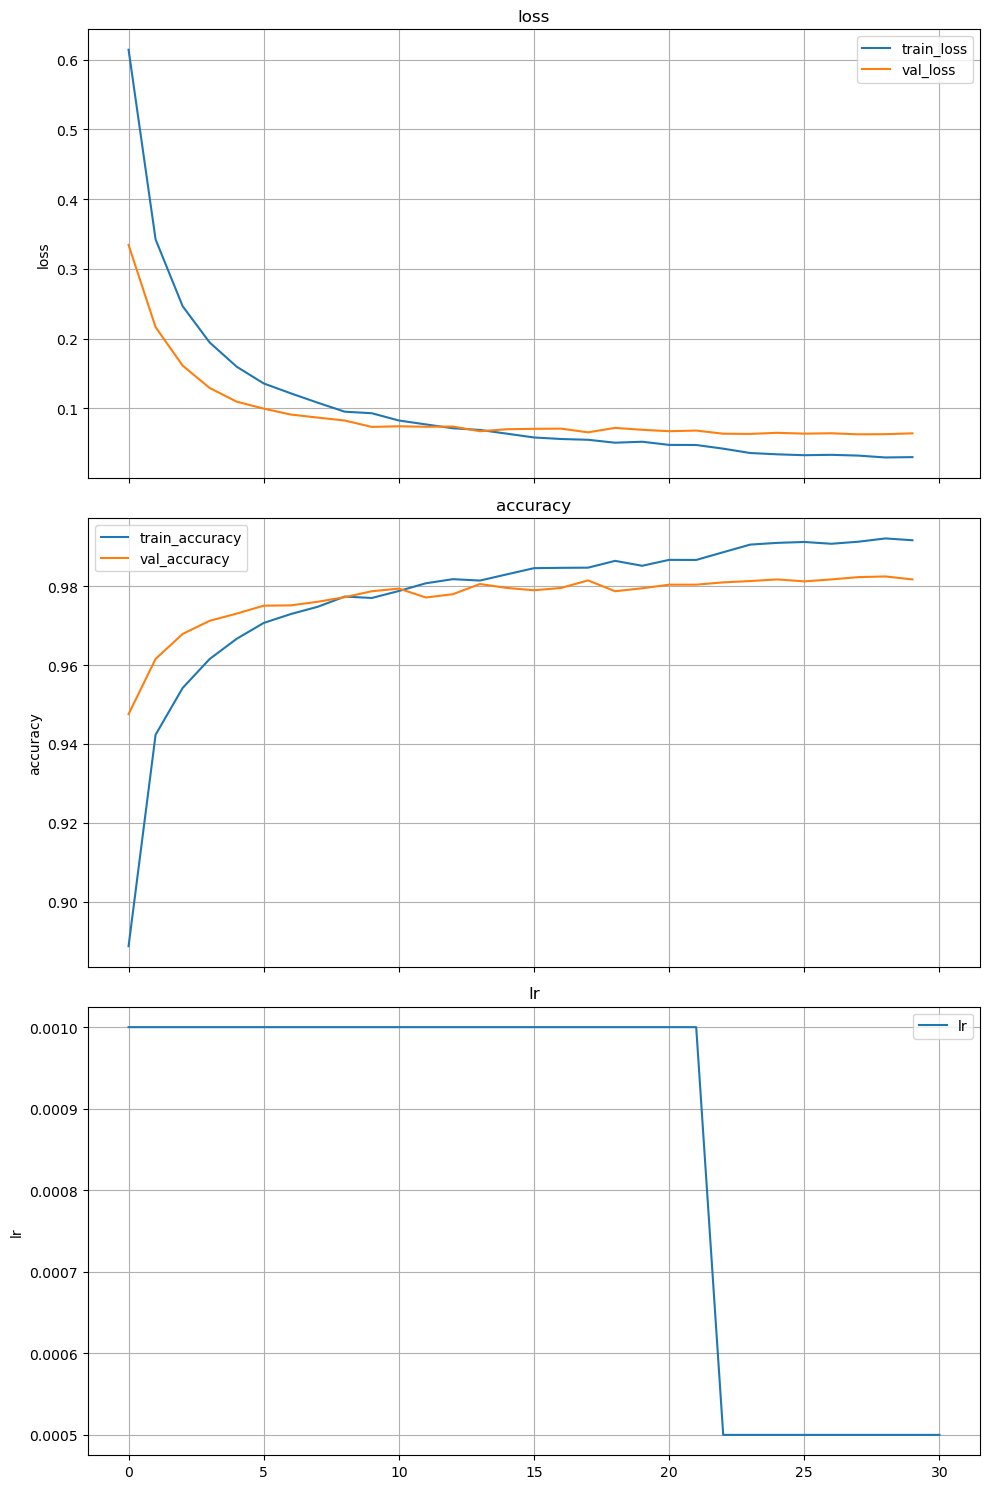

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [15]:
# Define and train a simple MLP model on MNIST dataset.

# Instantiate the MLP with 3 hidden layers, ReLU activations, batch norm, and dropout.
mlp_model = MLP(
    layer_sizes=[28*28, 128, 64, 10],
    act_funcs=[nn.ReLU, nn.ReLU, None],
    use_batch_norm=True,
    dropouts=[0.2, 0.2, 0.0]
)

# Set optimizer and learning rate scheduler.
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=EARLY_STOPPING_PATIENCE
)

# Initialize the training pipeline.
training_pipeline = SLTrainingPipeline(
    model=mlp_model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metrics=metrics,
    device=device,
    run_id='test_mlp_class',
    checkpoint_dir=CHECKPOINTS_DIR,
    log_dir=LOGS_DIR,
    callbacks=gradient_callbacks
)

# Run the training.
training_history = training_pipeline.fit(
    epochs=NUM_EPOCHS,
    train_loader=train_loader,
    val_loader=val_loader,
    verbose=False
)

# Load the best model checkpoint.
training_pipeline.load()

# Plot training metrics (loss, accuracy, etc.).
training_pipeline.plot()


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

## 🧩 Depth Competition: Standard MLP vs ResMLP on MNIST

### ✅ What the code does

- **Purpose**:  
  Compares the performance of a **standard Multi-Layer Perceptron (MLP)** and a **Residual MLP (ResMLP)** with varying depths on the MNIST digit classification task.

- **Depths tested**:  
  `[4, 8, 16, 32]` layers.

- **Model Setup**:  
  - Input dimension is flattened MNIST images (28x28 = 784).  
  - Hidden layers have fixed size `32`.  
  - Output layer size is 10 (number of MNIST classes).  
  - Sigmoid activations on all hidden layers except the last (which is linear).  
  - Xavier uniform initialization to highlight potential vanishing gradients in deep networks.

- **Training pipeline**:  
  For each depth value:  
  1. Create layer sizes list for input, hidden repeated `(depth - 1)` times, and output.  
  2. Instantiate and train a standard MLP with the above specs.  
  3. Instantiate and train a ResMLP with the same specs but **adds a skip connection** from layer 1 to layer `(depth - 2)` to help gradient flow.  
  4. Use Adam optimizer with a learning rate scheduler (`ReduceLROnPlateau`) to reduce LR on validation metric plateau.  
  5. Evaluate both models on test data and print results.

---

### 🔍 Why it’s done this way

- **Depth variations** test how increasing network depth affects performance and training stability.

- **Skip connections in ResMLP**:  
  Help alleviate the **vanishing gradient problem** by providing a shortcut path for gradients during backpropagation, improving training in deeper nets.

- **Sigmoid activations + Xavier init**:  
  This combination is prone to vanishing gradients, making the benefit of skip connections more visible.

- **ReduceLROnPlateau scheduler**:  
  Automatically lowers the learning rate when training stalls, improving convergence and preventing getting stuck on plateaus.

- **Separate training pipelines** for fair comparison and detailed logging for each depth/model variant.

---

### 🧠 Theoretical context

- **Vanishing Gradients**:  
  As networks get deeper, gradients may shrink exponentially, making learning ineffective. Skip connections create shorter paths for gradient flow, mitigating this.

- **Residual Networks**:  
  Inspired by ResNets, ResMLP applies similar skip connections to MLPs, demonstrating that residual connections benefit not only CNNs but also fully connected nets.

- **Training Dynamics**:  
  Monitoring validation metrics with LR scheduling and early stopping prevents overfitting and encourages robust learning.

---

*This setup is ideal to empirically show how skip connections improve training of deeper MLPs on image classification tasks like MNIST.*


In [16]:
# Depth competition: comparing standard MLP and ResMLP with varying depths on MNIST.
# ResMLP uses skip connections to alleviate vanishing gradients in deeper nets.

depth_values = [4, 8, 16, 32]
hidden_dim = 32
input_dim = 28 * 28
output_dim = 10

for depth in depth_values:
    # Define layer sizes: input, hidden repeated (depth-1) times, output.
    layers = [input_dim] + [hidden_dim] * (depth - 1) + [output_dim]
    # Activation functions: sigmoid for all but last (which has no activation).
    activations = [nn.Sigmoid] * (depth - 2)
    init_function = nn.init.xavier_uniform_  # Xavier init to highlight vanishing gradients.

    # Instantiate standard MLP.
    mlp_model = MLP(
        layer_sizes=layers,
        act_funcs=activations,
        init_funcs=init_function
    )

    optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=EARLY_STOPPING_PATIENCE
    )

    mlp_pipeline = SLTrainingPipeline(
        model=mlp_model,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        metrics=metrics,
        device=device,
        run_id=f'mlp_gradient_depth_{depth}',
        log_dir=LOGS_DIR,
        callbacks=gradient_callbacks
    )

    mlp_pipeline.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    mlp_results = mlp_pipeline.evaluate(test_loader, verbose=True)

    # Instantiate ResMLP with skip connection from layer 1 to layer (depth-2).
    resmlp_model = ResMLP(
        layer_sizes=layers,
        act_funcs=activations,
        init_funcs=init_function,
        skip_connections=[(1, depth - 2)]
    )

    optimizer = optim.Adam(resmlp_model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=EARLY_STOPPING_PATIENCE
    )

    resmlp_pipeline = SLTrainingPipeline(
        model=resmlp_model,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        metrics=metrics,
        device=device,
        run_id=f'resmlp_gradient_depth_{depth}',
        log_dir=LOGS_DIR,
        callbacks=gradient_callbacks
    )

    resmlp_pipeline.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    resmlp_results = resmlp_pipeline.evaluate(test_loader, verbose=True)


100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


training time: 33.67


test_loss: 0.1642
test_accuracy: 0.9554


100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


training time: 34.41


test_loss: 0.1380
test_accuracy: 0.9604


100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


training time: 44.73


test_loss: 0.6420
test_accuracy: 0.8308


100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


training time: 44.24


test_loss: 0.1577
test_accuracy: 0.9555


100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


training time: 64.87


test_loss: 1.0298
test_accuracy: 0.6269


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


training time: 65.28


test_loss: 0.1441
test_accuracy: 0.9550


100%|██████████| 30/30 [01:44<00:00,  3.48s/it]


training time: 104.44


test_loss: 2.3010
test_accuracy: 0.1135


100%|██████████| 30/30 [01:44<00:00,  3.49s/it]


training time: 104.67


test_loss: 0.1368
test_accuracy: 0.9599


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

## 📦 CIFAR-10 Dataset Loading and Preprocessing with Augmentation


- **Data augmentation pipeline (`cifar_transform`)**:  
  Applies a series of transformations to the CIFAR-10 images during loading:  
  - `RandomHorizontalFlip()`: randomly flips images horizontally to augment data diversity.  
  - `RandomCrop(32, padding=4)`: randomly crops 32x32 patches from images padded by 4 pixels on each side, adding spatial variability.  
  - `ToTensor()`: converts PIL images to PyTorch tensors (values scaled to [0,1]).  
  - `Normalize(mean, std)`: normalizes each channel using dataset-specific mean and std values to center data distribution.

- **Dataset Loading**:  
  - Downloads CIFAR-10 training and test sets.  
  - Applies the above augmentation only on training/validation data (via `transform=cifar_transform`).  
  - Uses the same transform on test set here, but often test transforms exclude augmentation for fair evaluation.

- **Train/Validation split**:  
  - Splits the original training set (50,000 images) into 80% training and 20% validation subsets using `random_split`.

- **DataLoaders**:  
  - Creates PyTorch `DataLoader` objects for training, validation, and test sets.  
  - Note: `shuffle=False` on training loader here (likely for a specific experimental reason, e.g. reproducibility or consistent batch order).  
  - Validation and test loaders shuffle the data.

---

*This code is the standard practice to prepare CIFAR-10 data with basic augmentation and splitting for training robust image classifiers.*


In [17]:
# CIFAR10 dataset loading and preprocessing with augmentation

cifar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

split_ratio = [0.8, 0.2]  # train/val split

cifar_train_val_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=cifar_transform)
cifar_test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=cifar_transform)

train_len = int(split_ratio[0] / sum(split_ratio) * len(cifar_train_val_dataset))
val_len = len(cifar_train_val_dataset) - train_len

cifar_train_dataset, cifar_val_dataset = torch.utils.data.random_split(cifar_train_val_dataset, [train_len, val_len])

train_loader = DataLoader(cifar_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)  # shuffle=False per es. 2.2
val_loader = DataLoader(cifar_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(cifar_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


100%|██████████| 170M/170M [00:14<00:00, 11.4MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 🏗️ Building and Training CNN vs ResCNN with Varying Depths on CIFAR-10

### ✅ What the code does

- **Setup:**  
  - `input_shape = (3, 32, 32)` for CIFAR-10 RGB images.  
  - `output_size = 10` classes.  
  - Defines three CNN depths: `[6, 12, 20]` convolutional layers.  
  - Calculates how many max-pooling layers to add based on input spatial size (`max_pool_layers`).

- **Architecture building:**  
  For each depth `d`:  
  - Divides `d` conv layers evenly across `max_pool_layers` blocks.  
  - Each block outputs feature maps with channels increasing as `[64, 128, 256, 512]`.  
  - Last conv layer in each block applies `MaxPool2d(kernel=2, stride=2)` for downsampling.  
  - Each conv layer uses 3x3 kernels, stride 1, padding 1, batch normalization, and ReLU activation.

- **MLP tail:**  
  After convolutional feature extraction, an MLP with a hidden layer (512 units, ReLU + dropout 0.5) maps features to final 10-class output.

- **Model variants:**  
  - **Standard CNN** with the defined architecture.  
  - **Residual CNN (ResCNN)** adding skip connections to improve gradient flow and performance.

- **Training pipeline:**  
  For each model (CNN and ResCNN):  
  - Adam optimizer with a learning rate scheduler that reduces LR on validation metric plateaus.  
  - Trains on training data, validates on validation set, for `NUM_EPOCHS`.  
  - Each training run is logged with unique `run_id` reflecting depth and model type.

---

### 🔍 Why it’s done this way

- **Variable depth experiments:**  
  To observe how increasing convolutional layers affects learning capacity and performance.

- **Block-wise design with pooling:**  
  Mimics standard CNN architectures where spatial dimensions reduce progressively, and channels increase to capture more complex features.

- **BatchNorm + ReLU:**  
  Batch normalization stabilizes training and accelerates convergence; ReLU activation helps mitigate vanishing gradients.

- **MLP tail:**  
  Bridges convolutional features to classification output with nonlinear mapping and regularization (dropout).

- **Residual connections (ResCNN):**  
  Help combat vanishing gradients in deep CNNs, enabling easier training of deeper networks by shortcutting gradient flow.

- **Learning rate scheduler:**  
  Automatically reduces LR if validation loss stops improving, encouraging better convergence.

---

### 🧠 Theoretical context

- **Deep CNNs** can extract hierarchical representations, but training very deep nets is challenging without skip connections.

- **Residual learning** enables identity mappings to ease optimization, shown famously in ResNet architectures.

- **Max pooling** down-samples feature maps to reduce spatial size, increasing receptive field and reducing computational load.

- **Batch normalization** normalizes intermediate layer outputs, reducing internal covariate shift.

---

*This experiment sets up a controlled comparison between classical CNNs and residual CNNs with increasing depth, showcasing the importance of architectural innovations to train deeper models effectively on CIFAR-10.*


In [18]:
import math
import torch.optim as optim
import torch.nn as nn

input_shape = (3, 32, 32)
output_size = 10

depths = [6, 12, 20]  # Number of convolutional layers
max_pool_layers = int(math.log(min(input_shape[1], input_shape[2]), 2) - 2)  # Number of max pooling layers
chan_per_block = [64, 128, 256, 512]

def build_mlp_tail(cnn_output_size, output_size=10, hidden_dim=512):
    return MLP(
        layer_sizes=[cnn_output_size, hidden_dim, output_size],
        act_funcs=[nn.ReLU, None],  # ReLU should suffer less from vanishing gradients
        dropouts=[0.5, 0.0],
        use_bias=True
    )

for i, d in enumerate(depths):
    architecture = []

    for block in range(max_pool_layers):
        # Distribute conv layers evenly among blocks
        num_conv = d // max_pool_layers if block != max_pool_layers - 1 else d - (max_pool_layers - 1) * (d // max_pool_layers)
        out_chan = chan_per_block[block]

        for conv in range(num_conv):
            layer_config = {
                "out_channels": out_chan,
                "kernel": 3,
                "stride": 1,
                "padding": 1,
                "use_batch_norm": True,
                "act_func": nn.ReLU
            }

            if conv == num_conv - 1:
                layer_config["pool"] = nn.MaxPool2d
                layer_config["pool_kernel"] = 2
                layer_config["pool_stride"] = 2
                layer_config["pool_padding"] = 0

            architecture.append(layer_config)

    # Standard CNN
    cnn = CNN(input_shape, architecture)
    cnn_output_size = cnn.get_output_size()

    mlp_tail_cnn = build_mlp_tail(cnn_output_size, output_size=output_size)
    cnn.attach_mlp(mlp_tail_cnn)

    optimizer_cnn = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
    scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=EARLY_STOPPING_PATIENCE)

    pipeline_cnn = SLTrainingPipeline(
        model=cnn,
        optimizer=optimizer_cnn,
        lr_scheduler=scheduler_cnn,
        metrics=metrics,
        device=device,
        run_id=f'cnn_{d}convs',
        log_dir=LOGS_DIR,
    )

    history_cnn = pipeline_cnn.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    # ResCNN with skip connections
    rescnn = ResCNN(input_shape, architecture)
    rescnn_output_size = rescnn.get_output_size()

    mlp_tail_rescnn = build_mlp_tail(rescnn_output_size, output_size=output_size)
    rescnn.attach_mlp(mlp_tail_rescnn)

    optimizer_rescnn = optim.Adam(rescnn.parameters(), lr=LEARNING_RATE)
    scheduler_rescnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rescnn, mode='min', factor=0.5, patience=EARLY_STOPPING_PATIENCE)

    pipeline_rescnn = SLTrainingPipeline(
        model=rescnn,
        optimizer=optimizer_rescnn,
        lr_scheduler=scheduler_rescnn,
        metrics=metrics,
        device=device,
        run_id=f'rescnn_{d}convs',
        log_dir=LOGS_DIR,
    )

    history_rescnn = pipeline_rescnn.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )


100%|██████████| 30/30 [01:38<00:00,  3.29s/it]


training time: 98.73


100%|██████████| 30/30 [03:28<00:00,  6.96s/it]


training time: 208.89


100%|██████████| 30/30 [03:10<00:00,  6.35s/it]


training time: 190.62


100%|██████████| 30/30 [06:45<00:00, 13.51s/it]


training time: 405.28


100%|██████████| 30/30 [05:12<00:00, 10.40s/it]


training time: 312.09


100%|██████████| 30/30 [10:44<00:00, 21.50s/it]

training time: 644.97


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [19]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

## 🔄 Callbacks to Save Soft Labels (Logits) During Teacher Model Evaluation

### ✅ What the code does

- **Purpose:**  
  Saves the **logits** (raw output scores before softmax) produced by a teacher model on the **training set** during evaluation mode—without updating gradients.

- **Why during evaluation?**  
  - Although logits can be obtained during training, saving them during **evaluation** is simpler and safer, since no gradients are computed or updated.  
  - The training dataset is passed through the model in evaluation mode just to extract and save logits (soft labels).  
  - This setup is easier to integrate with the training pipeline class.

- **Callbacks:**

  1. `activate_logits_saving`:  
     - Triggered at the start of evaluation (`on_eval_begin`).  
     - Sets a flag `save_logits = True` and initializes an empty list `soft_labels` to store logits.

  2. `save_logits`:  
     - Called at the end of every batch (`on_batch_end`).  
     - Checks if it is **not training** mode (`is_training=False`) and `save_logits` flag is active.  
     - Retrieves the batch logits from context and appends their detached CPU copy to the `soft_labels` list to avoid affecting computation graph or device memory.

- **Callbacks dictionary:**  
  Hooks these functions into the training pipeline’s event system.

---

### 🔍 Why it’s done this way

- **Separate logits saving from training:**  
  Avoids interfering with training computations and gradient updates.

- **Detaching logits and moving to CPU:**  
  Saves memory and ensures logits are stored safely outside the computation graph, preventing unintended backpropagation or memory leaks.

- **Use of callbacks and pipeline flags:**  
  Cleanly integrates with the existing pipeline architecture for modularity and ease of reuse.

---

### 🧠 Theoretical context

- **Soft labels (teacher logits)** are useful for knowledge distillation, where a student model learns from the teacher’s output distribution rather than hard labels.

- **Evaluation mode** disables dropout and batch norm updates, producing stable outputs for saving logits.

- **Detaching tensors** prevents gradients from flowing backward and frees GPU memory, essential during large dataset evaluations.

---

*This pattern efficiently collects soft labels from a teacher model for distillation or analysis without disrupting the training process.*


In [20]:

# This allows us to collect soft labels for further analysis or distillation.

def activate_logits_saving(pipeline, **context):
    pipeline.callbacks_data["save_logits"] = True
    pipeline.callbacks_data["soft_labels"] = []


def save_logits(pipeline, **context):
    if context.get("is_training", True):
        return
        
    if not pipeline.callbacks_data.get("save_logits", False):
        return

    logits = context.get("logits")
    
    if logits is not None:
        pipeline.callbacks_data["soft_labels"].append(logits.detach().cpu())

callbacks = {
    "on_eval_begin": [activate_logits_saving],
    "on_batch_end": [save_logits]
}

## 🏗️ ResNet-34 Teacher Model for Soft Label Generation

### ✅ What the code does

- **ResNet-34 architecture setup:**  
  - Builds a residual network with `depth=34` layers, structured into 4 stages with blocks per stage: `[3, 4, 6, 3]`.  
  - Each stage outputs feature maps with increasing channels: `[64, 128, 256, 512]`.  
  - The first block of each stage (except the first stage) downsamples spatially by setting `stride=2`.  
  - Each block configured with no dropout and no pooling (pooling is implicit in strides).

- **Model instantiation:**  
  - Creates a `ResCNN` model with the defined residual layers, using `BasicBlock` residual units and batch normalization (`nn.BatchNorm2d`).  
  - Input shape is `(3, 32, 32)` (CIFAR-10 images).

- **MLP head (tail):**  
  - Maps the CNN output to classification logits via a two-layer MLP:  
    - Hidden layer: 512 units with ReLU and dropout 0.5.  
    - Output layer: 10 units (number of classes), **no activation** specified here (comment suggests softmax could be added, but typically left out because loss functions like `CrossEntropyLoss` apply it internally).

- **Optimizer and scheduler:**  
  - Adam optimizer with learning rate scheduler reducing LR on plateau of validation loss.

- **Training pipeline:**  
  - Uses `SLTrainingPipeline` with model, optimizer, scheduler, metrics, device, and callback hooks (including soft labels saving callbacks).  
  - Runs training for `NUM_EPOCHS`.  
  - Logs are saved and checkpoints handled.

- **Post-training steps:**  
  - Plots training history.  
  - Calls `evaluate` **on the training loader** in evaluation mode specifically to compute and save **soft labels (logits)** for the training set (used later for knowledge distillation).  
  - Extracts stored soft labels from the pipeline callback data.

---

### 🔍 Why it’s done this way

- **ResNet-34 teacher model:**  
  Standard deep residual network to provide strong teacher predictions for distillation.

- **Stride-based downsampling:**  
  Replaces explicit pooling with strided convolutions in first block of stages to reduce spatial dimension.

- **MLP tail design:**  
  Common practice to flatten convolutional features and project to output classes via fully connected layers.

- **Softmax activation omitted in final layer:**  
  Typically, loss functions (like cross-entropy) combine softmax internally; outputs are raw logits.

- **Evaluating on training set for logits saving:**  
  Runs the model in eval mode on training data to get stable logits for soft label distillation without affecting model weights.

---

### 🧠 Theoretical context

- **Residual blocks and skip connections** enable effective training of very deep networks by mitigating vanishing gradients.

- **Soft labels (logits)** contain richer information than hard labels, reflecting class probabilities and inter-class similarities, improving student model training via knowledge distillation.

- **Training and validation split** ensures model generalization is tracked during training, with checkpoints safeguarding progress.

---

*This code prepares a ResNet-34 teacher network, trains it, and generates soft labels from the training data to enable downstream knowledge distillation.*


100%|██████████| 30/30 [08:23<00:00, 16.79s/it]


training time: 503.61


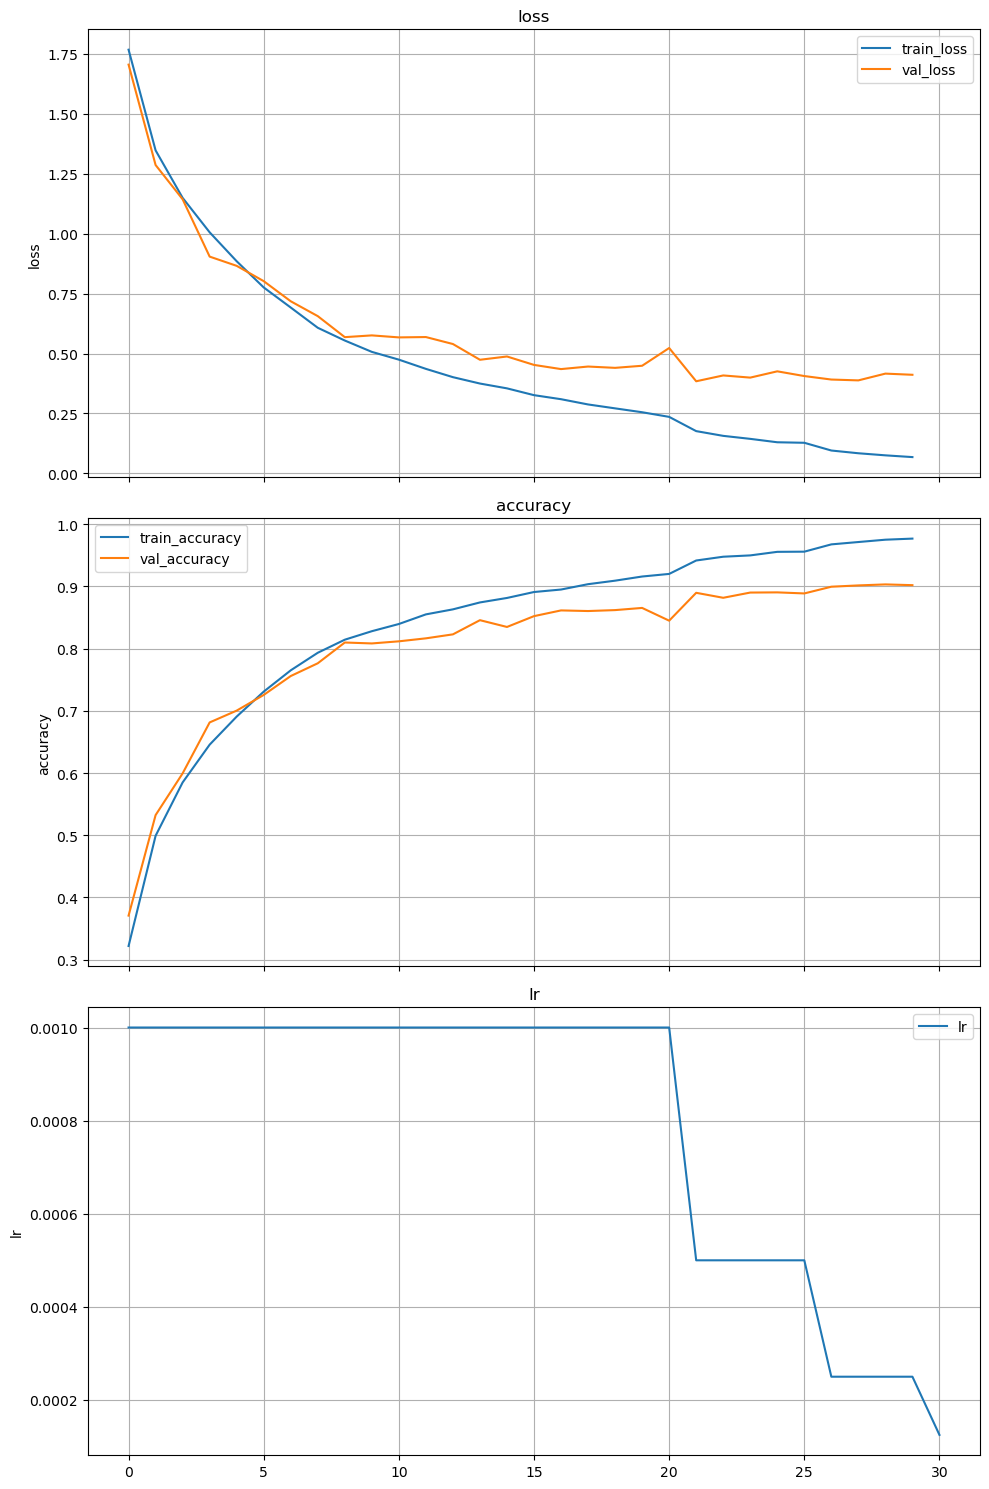

In [21]:


res_layers_teacher = []
depth = 34
blocks_per_stage = [3, 4, 6, 3]
channels = [64, 128, 256, 512]
input_shape = (3, 32, 32)

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_teacher.append(layer_config)

teacher = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_teacher,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = teacher.get_output_size()
mlp_tail = MLP( #should i put softmax as act func? probably yes
    layer_sizes = [output_size, 512, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.5, 0.0],
    use_bias = True
)
teacher.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(teacher.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = EARLY_STOPPING_PATIENCE)

pipeline = SLTrainingPipeline(
    model = teacher,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'teacher',
    log_dir = LOGS_DIR,
    checkpoint_dir = "." + CHECKPOINTS_DIR,
    callbacks = callbacks
)

history = pipeline.fit(epochs = NUM_EPOCHS, train_loader =train_loader, val_loader = val_loader, verbose = False)
#pipeline.load()

pipeline.plot()
#Just using evaluation to compute soft_labels, that's why test_loader is train_loader
pipeline.evaluate(test_loader = train_loader, verbose = False)

soft_labels = pipeline.get_callbacks_data()["soft_labels"]

## 🎓 Smaller ResNet Student Model for Distillation

### ✅ What the code does

- **Student ResNet architecture setup:**  
  - Builds a **smaller residual network** with fewer layers and channels compared to the teacher:  
    - `blocks_per_stage = [1, 2, 1]` → total 4 residual blocks across 3 stages (versus many more in teacher).  
    - Channels increase as `[32, 64, 128]`.  
  - Downsampling (stride=2) applied at first block of each stage after the first, reducing spatial resolution progressively.  
  - Each block configured with no dropout and no explicit pooling.

- **Model instantiation:**  
  - Creates a `ResCNN` student model with the above residual layers, using the same `BasicBlock` and batch norm.  
  - Input shape remains `(3, 32, 32)`.

- **MLP head (tail):**  
  - Smaller MLP classifier tail:  
    - Hidden layer with 256 units, ReLU activation, dropout 0.3 (slightly less capacity than teacher’s 512 units).  
    - Output layer: 10 classes, no activation (logits output).

- **Optimizer and scheduler:**  
  - Adam optimizer with the same learning rate scheduling strategy as teacher.

- **Training pipeline setup:**  
  - Creates a pipeline for supervised training using `SLTrainingPipeline`.  
  - Associates model, optimizer, scheduler, metrics, device, logging, and checkpoint directories.

- **Training call commented out:**  
  - Training is not executed in this snippet (`pipeline_student.fit` is commented).  
  - Instead, the pipeline attempts to **load pre-trained weights** from checkpoint with `pipeline_student.load()`.

- **Plotting training history:**  
  - Visualizes the loaded training progress/history via `pipeline_student.plot()`.

---

### 🔍 Why it’s done this way

- **Student model is smaller and less deep:**  
  Designed to be more efficient and faster to train/infer compared to the teacher, typical in knowledge distillation setups.

- **Reduced MLP tail size:**  
  Matches smaller feature representation and helps avoid overfitting.

- **Loading pre-trained weights instead of training:**  
  Useful for continuing experiments, evaluating, or resuming from checkpoints without re-running the entire training.

- **Pipeline abstraction:**  
  Maintains consistent training/evaluation flow with the teacher setup for easier comparison.

---

### 🧠 Theoretical context

- **Knowledge distillation**: student is a compressed version of teacher, learning from teacher’s soft labels to approximate its performance with fewer parameters.

- **Residual blocks and batch norm**: help stabilize training in deeper models; still used here to enable efficient student training.

- **Learning rate scheduling and early stopping patience**: prevent overfitting and adapt learning dynamically.

---

*This code sets up a smaller ResNet-based student model, prepared for training or loading pretrained weights, as part of a distillation pipeline.*  


/home/marco/Desktop/University/DLA/Labs (1,2,3)/BaseTrainingPipeline.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map_location = self

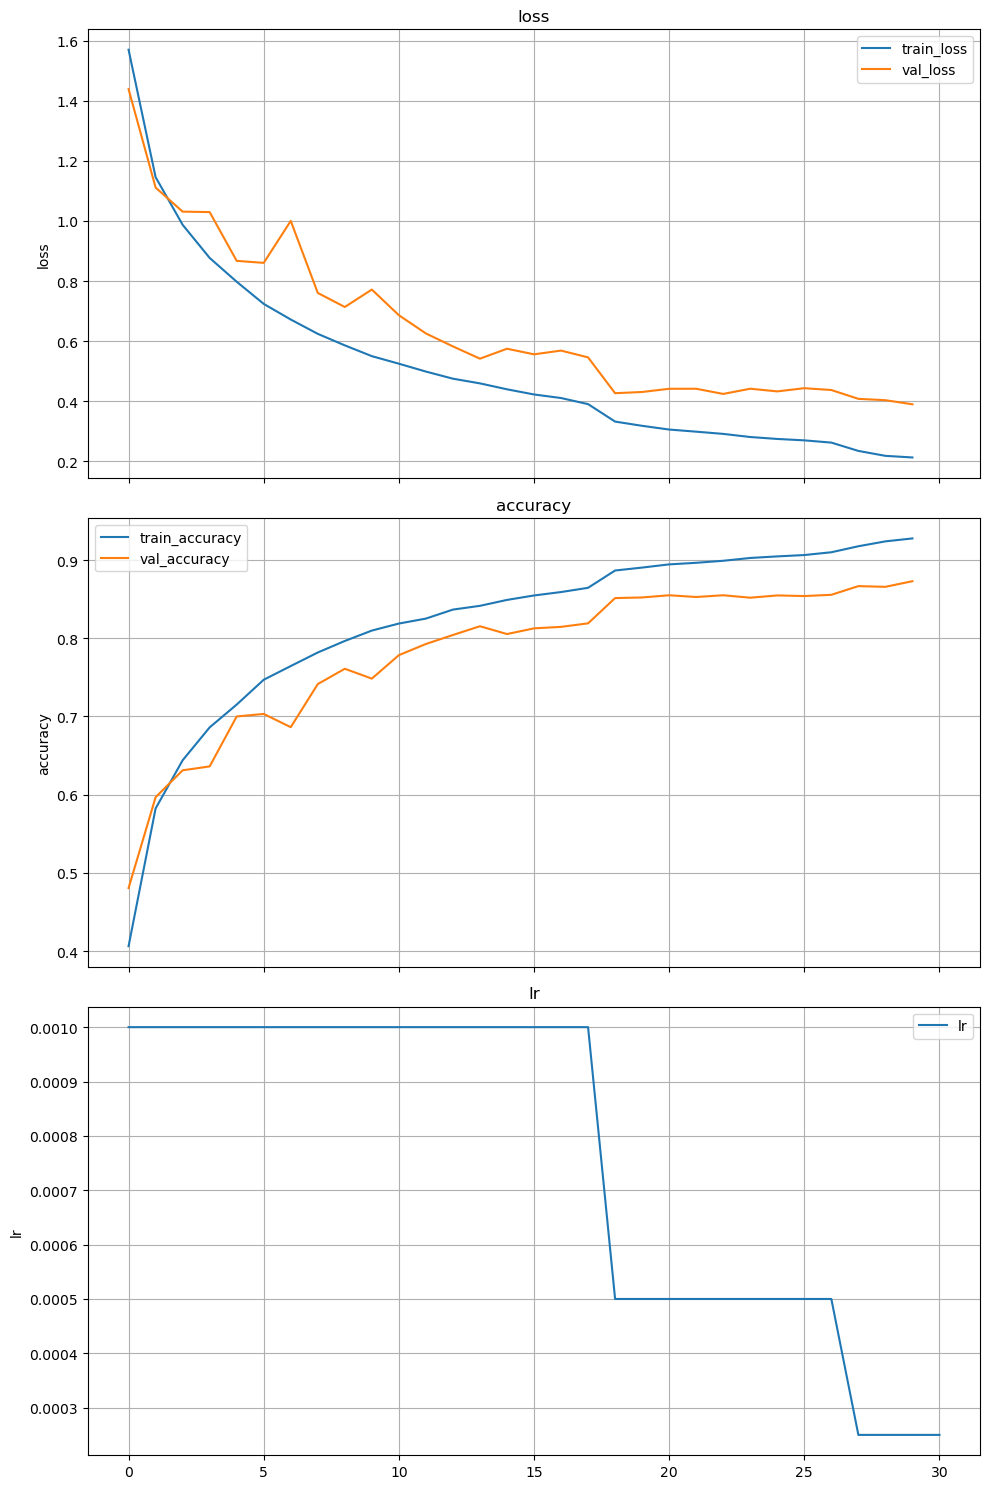

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [22]:


res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = EARLY_STOPPING_PATIENCE)

pipeline_student = SLTrainingPipeline(
    model = student,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student',
    log_dir = LOGS_DIR,
    checkpoint_dir = "."+CHECKPOINTS_DIR
)

#history_student = pipeline_student.fit(
#    epochs = n_epochs,
#    train_loader = train,
#    val_loader = val,
#    verbose = False
#)

pipeline_student.load()

pipeline_student.plot()

## 📚 Custom Dataset for Knowledge Distillation: `DistillationDataset`


- **Purpose:**  
  Wraps an existing dataset to provide **both hard labels and soft labels** for distillation training.

- **Initialization (`__init__`):**  
  - Takes two inputs:  
    - `original_dataset`: the base dataset (e.g., images + hard labels).  
    - `soft_labels`: a NumPy array of soft labels (typically teacher logits or probabilities).  
  - Converts `soft_labels` from NumPy array to a PyTorch tensor with dtype `float`.  
  - Checks that dataset and soft labels lengths match to avoid misalignment.

- **Length (`__len__`):**  
  - Returns the number of samples in the dataset.

- **Item access (`__getitem__`):**  
  - Retrieves the input data `X` and the original hard label from `original_dataset`.  
  - Retrieves corresponding soft label from `soft_labels`.  
  - Returns a tuple: `(X, (hard_label, soft_label))`.  
    - This allows the training loop to access both labels simultaneously for combined loss calculation.




In [23]:


class DistillationDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, soft_labels):

        self.original_dataset = original_dataset

        #suppose soft_labels a numpy array
        self.soft_labels = torch.from_numpy(soft_labels).float()
        
        assert len(self.original_dataset) == len(self.soft_labels), "Length mismatch between original dataset and soft labels."
        
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        X, hard_label = self.original_dataset[idx]
        soft_label = self.soft_labels[idx]
        return X, (hard_label, soft_label)

## 🎯 Distillation Loss: Combining Hard and Soft Label Supervision

### ✅ What the code does

- **Class `DistillationLoss` inherits from `nn.Module`:**  
  Implements a custom loss function combining standard classification loss and distillation loss.

- **Constructor (`__init__`):**  
  - `temperature`: smoothing parameter to soften logits (higher → softer probabilities).  
  - `alpha`: weighting factor balancing hard-label loss and soft-label loss.  
  - `base_criterion`: default is `CrossEntropyLoss` for hard label classification.  
  - Defines a `KLDivLoss` with `batchmean` reduction for measuring divergence between teacher and student soft predictions.

- **Forward method (`forward`):**  
  - Accepts `y` (student model logits) and `targets`.  
  - If `targets` is not a tuple of length 2 (hard and soft labels), just applies base criterion on `y` and `targets` (standard supervised loss).  
  - Otherwise:  
    - Unpacks `targets` into `hard` (hard labels) and `soft` (teacher soft labels/logits).  
    - Computes hard loss: `loss_hard = base_criterion(y, hard)` (e.g., cross entropy).  
    - Computes softened student probabilities: `p = log_softmax(y / temperature)`.  
    - Computes softened teacher probabilities: `q = softmax(soft / temperature)`.  
    - Computes soft loss as KL divergence between softened outputs: `loss_soft = KLDivLoss(p, q) * temperature²`.  
    - Returns combined loss:  
      \[
      \text{loss} = \alpha \times \text{loss_hard} + (1 - \alpha) \times \text{loss_soft}
      \]

---

### 🔍 Why it’s done this way

- **Temperature scaling:**  
  Softens the logits to reveal dark knowledge — finer class similarity information.

- **KL divergence loss:**  
  Measures how close the student’s softened output distribution matches the teacher’s softened outputs.

- **Weighted sum with `alpha`:**  
  Balances learning from true labels (`hard`) and from teacher’s output distribution (`soft`).

- **Fallback behavior:**  
  If soft labels are not provided, falls back to standard supervised loss.



In [24]:
#Distillation criterion 

import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temperature, alpha, base_criterion = nn.CrossEntropyLoss()):
        super().__init__()
        
        self.base_criterion = base_criterion
        self.temperature = temperature
        self.alpha = alpha

        self.kl_div_loss = nn.KLDivLoss(reduction = 'batchmean') #Kullback-Leibler divergence loss

    def forward(self, y, targets):
        if not isinstance(targets, tuple) or len(targets) != 2:
            loss = self.base_criterion(y, targets)
            return loss

        hard, soft = targets

        loss_hard = self.base_criterion(y, hard)

        p = F.log_softmax(y/self.temperature, dim = 1)
        q = F.softmax(soft/self.temperature, dim = 1)

        loss_soft = self.kl_div_loss(p, q) * (self.temperature ** 2)

        loss = self.alpha * loss_hard + (1 - self.alpha) * loss_soft
        return loss

## 📊 Distillation Accuracy Metric

### ✅ What the code does

- Defines a function `distillation_accuracy` to compute accuracy during distillation training.

- **Input:**  
  - `logits`: model raw outputs (before softmax).  
  - `targets`: either just hard labels or a tuple `(hard_labels, soft_labels)`.

- **Logic:**  
  - If `targets` is a tuple or list, extracts the hard labels (first element).  
  - If `targets` is not a tensor (e.g., None or other type), returns accuracy as `0.0` to avoid errors.  
  - Uses `torch.max(logits.data, 1)` to get predicted class indices.  
  - Compares predicted indices with hard labels to compute mean accuracy as a float scalar.

- **Result:**  
  Returns the classification accuracy on hard labels as a Python float.

- Assigns this function as `"accuracy"` in a dictionary `metrics` for easy integration into training pipelines.

---

### 🔍 Why it’s done this way

- **Handles both normal and distillation targets:**  
  Targets may include soft labels during distillation, but accuracy is computed only on hard (true) labels.

- **Robustness check:**  
  Returns 0.0 if hard labels are missing or not tensor, preventing runtime errors.

- **Simple accuracy computation:**  
  Compares predictions with hard labels, providing an intuitive and standard metric for classification.




In [25]:
#Distillation accuracy metric

def distillation_accuracy(logits, targets):
    if isinstance(targets, (list, tuple)):
        hard_labels = targets[0]
    else:
        hard_labels = targets

    if not isinstance(hard_labels, torch.Tensor):
        return 0.0

    _, predicted = torch.max(logits.data, 1)

    return (predicted == hard_labels).float().mean().item()

metrics = {"accuracy": distillation_accuracy}

## 🎓 Student Model Training After Lectures with Distillation

### ✅ What the code does

- **Prepares distillation dataset:**  
  - Concatenates saved soft labels (`soft_labels` list) into one tensor (`soft_labels_tensor`) and converts to NumPy (`soft_labels_numpy`).  
  - Wraps original CIFAR training set and soft labels in `DistillationDataset`, which returns input plus both hard and soft labels.  
  - Creates DataLoader `train` from this dataset (no shuffle here).

- **Defines distillation loss:**  
  - Sets `temperature=4.0` and `alpha=0.7`.  
  - Uses the `DistillationLoss` combining cross-entropy on hard labels and KL divergence on soft labels with these parameters.

- **Adjusts learning rate:**  
  - Uses a higher learning rate (`lr = 10 * LEARNING_RATE`) as suggested by distillation literature, since soft labels carry richer information.

- **Defines a smaller ResCNN student architecture:**  
  - With fewer residual blocks and smaller channel sizes (`blocks_per_stage` and `channels`).  
  - Constructs residual layers similarly to before.

- **Builds the student model:**  
  - Creates `ResCNN` with student layers and attaches an MLP head (hidden size 256).  
  - Uses ReLU activation and dropout in MLP tail.

- **Setup optimizer and scheduler:**  
  - Adam optimizer with the higher learning rate.  
  - Learning rate scheduler reduces LR on plateau with patience of 3 epochs.

- **Configures training pipeline:**  
  - Passes student model, distillation loss, optimizer, scheduler, metrics, device, run ID, log and checkpoint directories to `SLTrainingPipeline`.

- **Trains the student:**  
  - Calls `fit` with the distillation dataset loader and validation loader.  
  - Loads best checkpoint after training.  
  - Plots training progress.

---

### 🔍 Why it’s done this way

- **Distillation Dataset:**  
  Encapsulates soft labels alongside original data to provide both targets during training, enabling the student to learn from the teacher's "soft" output distribution.

- **Higher Learning Rate:**  
  Soft labels are more informative, so the training can use a larger learning rate safely to converge faster.

- **Smaller Student Model:**  
  Student is a compressed model with fewer layers and smaller widths, aiming to learn distilled knowledge efficiently.

- **Use of Distillation Loss:**  
  Balances learning from true labels (`hard`) and soft labels (`teacher output`) to improve generalization.

- **Learning Rate Scheduler:**  
  Helps refine training by lowering LR when validation loss plateaus, preventing overfitting and helping convergence.

---

### 🧠 Context

This process implements knowledge distillation:  
- A large, well-trained teacher model generates soft label distributions.  
- The smaller student model is trained on the original inputs plus these soft labels, learning richer representations beyond hard labels alone.  
- The use of temperature and alpha controls the mix of hard and soft targets to optimize learning.

This pipeline fine-tunes the student to approximate the teacher’s behavior while being smaller and more efficient.


100%|██████████| 30/30 [03:20<00:00,  6.68s/it]

training time: 200.49


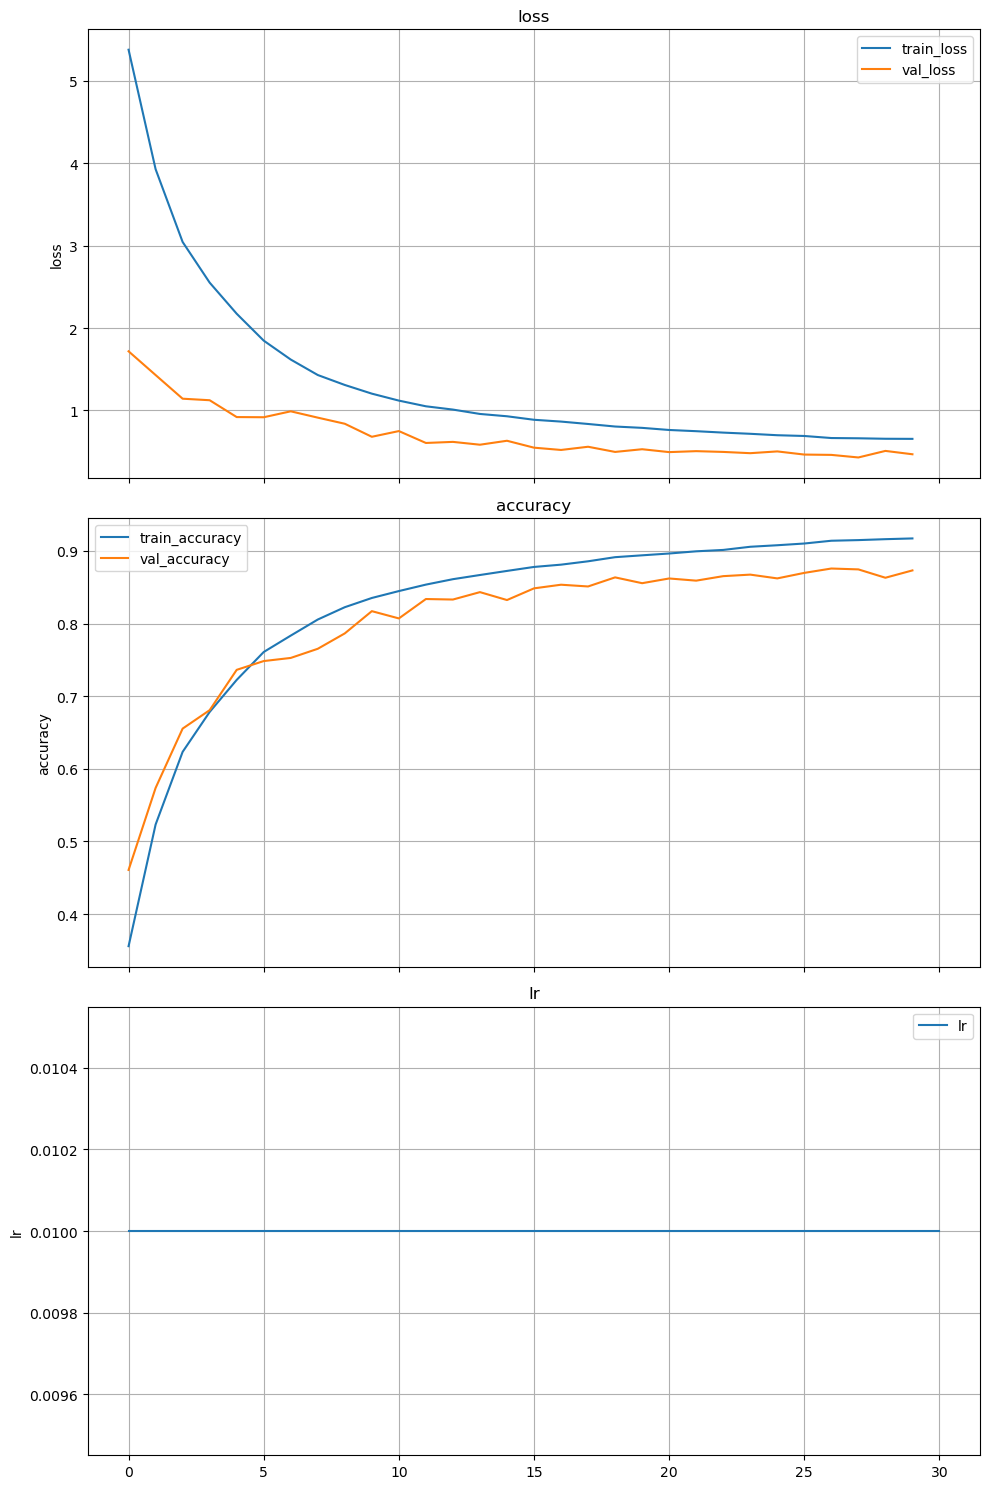

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [26]:

soft_labels_tensor = torch.cat(soft_labels, dim = 0)
soft_labels_numpy = soft_labels_tensor.numpy()

train_dataset = DistillationDataset(cifar_train_dataset, soft_labels_numpy)
train = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)

temperature = 4.0
alpha = 0.7
distill_criterion = DistillationLoss(temperature = temperature, alpha = alpha)

lr = 10 * LEARNING_RATE #paper says to work with higer lr since we have more meaningful labels

res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

pipeline_student = SLTrainingPipeline(
    model = student,
    criterion = distill_criterion,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student_after_lectures',
    log_dir = LOGS_DIR,
    checkpoint_dir = CHECKPOINTS_DIR
)

history_student = pipeline_student.fit(
    epochs = NUM_EPOCHS,
    train_loader = train,
    val_loader = val_loader,
    verbose = False
    )

pipeline_student.load()

pipeline_student.plot()

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [27]:
# Your code here.